<font color='blue'>
<br><h1>CONTENT:</h1>

 * [LOADING LIBRARY](#1)
 * [INTILIZATION](#2)
 * [DATA LOADING AnD PREPRATION](#3)
 * [MODELING](#4)
 * [APPLY RESNET50](#5)
 * [TRAINING AND OPTIMIZATION](#6)
 * [TESTING](#7)
 * [CONCLUSION](#8)

<a id="1"></a>
# LOADING LIBRARY

This Python code implements an image categorization deep learning model using TensorFlow. It imports different TensorFlow tools and modules for modelling neural networks, preparing data, and calculating evaluation metrics. For image classification tasks, it makes use of well-known pre-trained models as EfficientNetB4, ResNet50, and MobileNetV2. It also has the ability to use TensorFlow Datasets to load and preprocess image data. The code uses TensorFlow's Keras high-level deep learning API for model building and training. Additionally, it incorporates performance indicators like recall, precision, and accuracy. The script is configured to block alert messages.

In [39]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Input, Layer, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.metrics import (BinaryAccuracy,SparseTopKCategoricalAccuracy, SparseCategoricalAccuracy, 
                                      Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision,
                                      Recall, AUC)
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB4, ResNet50, MobileNetV2
from tensorflow.data.experimental import AUTOTUNE
import time
import pandas as pd
from shutil import copy2
import tensorflow_datasets

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# INTILIZATION

In [40]:
BATCH_SIZE = 32
INPUT_DIM = 224
NUM_EPOCHS = 20

<a id='3'></a>
# DATA LOADING AnD PREPRATION

This code snippet deals with data exploration and preparation for a TensorFlow breast cancer histology picture classification assignment. Here is comprehensive documentation:

The training picture data's directory path is kept in the train_directory variable. However, since train_directory is a string expressing the directory path, it lacks a.shape attribute.

train_dataset: This code block creates a training dataset from the photos in the train_directory using tf.keras.preprocessing.image_dataset_from_directory. The validation split (10%), the image size, and the batch size are some of the parameters that are used to construct the dataset. For effectively loading and preparing picture data for machine learning applications, it's a crucial step.

validation_data: Similar to the previous code block, but with a different subset ("validation") and a higher batch size, this one constructs a validation dataset with the same function. In order to assess model performance during training, validation datasets are used.

class_names: This line displays the labels for each class that was identified in the training dataset. These designations are derived from the train_directory's subdirectories.

Visualisation: This section of the code creates a grid of photos together with the labels for each of the associated classes. Visually inspecting the data to make sure it's loaded properly is a helpful step.

Validation_data: Similar to the previous code block, validation_data builds a validation dataset using the same procedure, but with a different subset ("validation") and a bigger batch size. In order to assess model performance during training, validation datasets are used.

class_names: This line displays the labels for each class that was identified in the training dataset. These designations are derived from the train_directory's subdirectories.

Visualisation: This section of the code creates a grid of photos together with the labels for each of the associated classes. Visually inspecting the data to make sure it's loaded properly is a helpful step.

Data loading performance is improved by the code's caching and prefetching of the training and validation datasets. In order to reduce idle time, prefetching overlaps data loading with model training while caching keeps the data in memory for faster access.



In [41]:
train_directory = "/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_directory, 
                                                                    validation_split=0.1,
                                                                    subset="training",
                                                                    seed = 999,
                                                                    image_size=(INPUT_DIM, INPUT_DIM),
                                                                    batch_size = BATCH_SIZE
                                                                    )
validation_data = tf.keras.preprocessing.image_dataset_from_directory(train_directory,
                                                                     validation_split= 0.1,
                                                                     subset="validation",
                                                                     seed=999,
                                                                     image_size = (INPUT_DIM, INPUT_DIM),
                                                                     batch_size =790
                                                                     )

Found 7909 files belonging to 2 classes.
Using 7119 files for training.
Found 7909 files belonging to 2 classes.
Using 790 files for validation.


In [6]:
print(train_dataset.class_names)
print(train_dataset)
class_names = train_dataset.class_names

['benign', 'malignant']
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


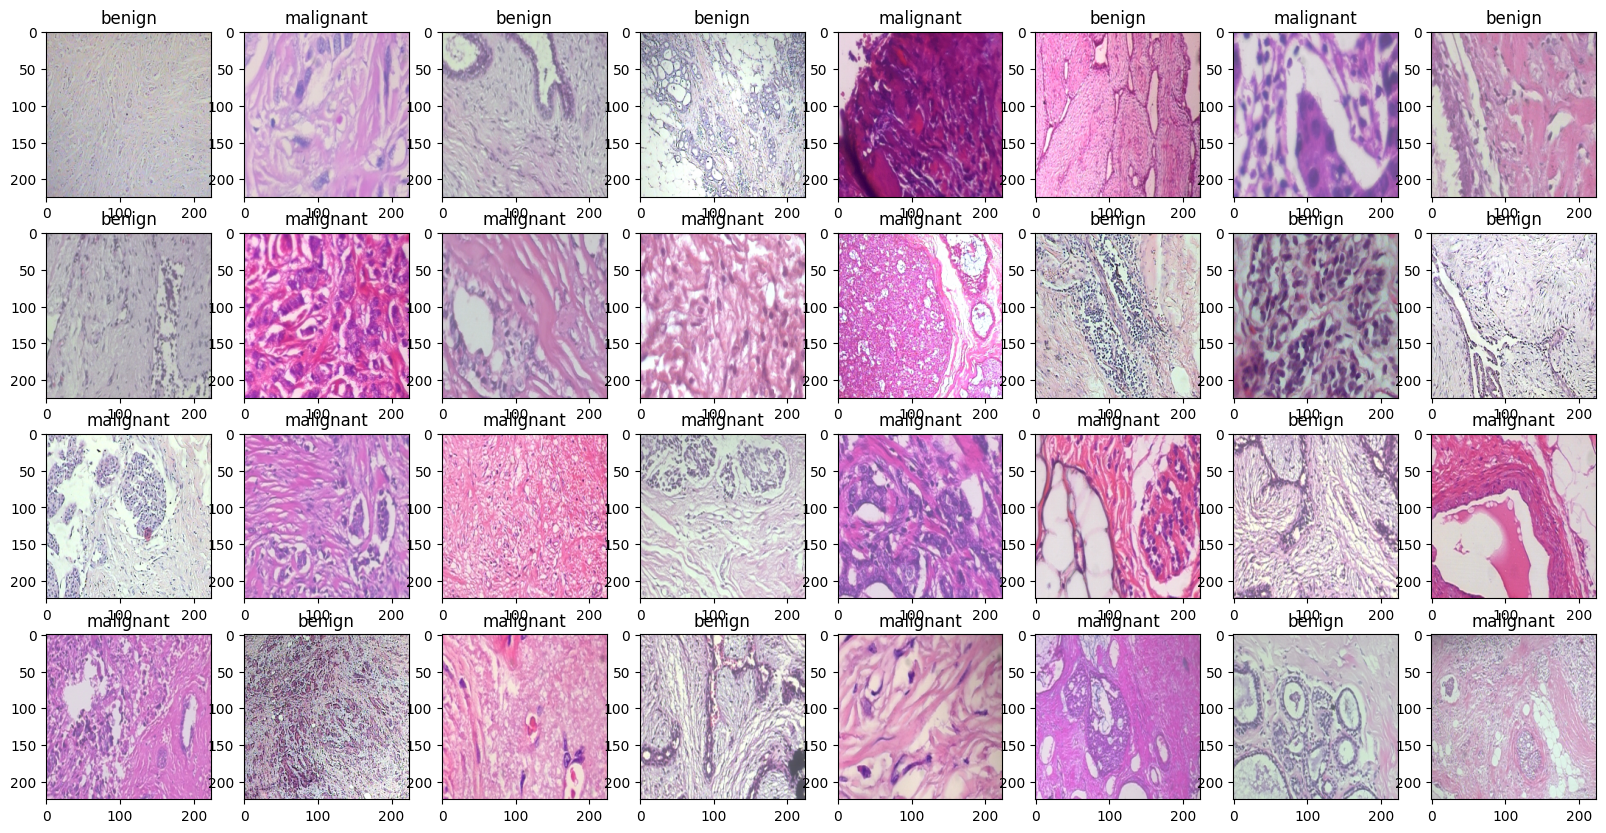

In [7]:
plt.figure(figsize=(20,10))

for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(BATCH_SIZE//8, BATCH_SIZE//4, i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[labels[i]])

In [22]:
train_dataset = train_dataset.cache().prefetch(buffer_size = AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
validation_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<a id='4'></a>
# MODELING

1. Take a image with [batch_size * 224 * 224 *3] shape
2. Then resnet Model Backbone is trained by imagenet
3. It shape will be [batch_size, 224/32 * 224/32 * 32] = [batch_size,7*7* 32]
4. Apply the Global average pooling and it shape will be [batch_size, 2048]
5. Then dense layer will be appeared and make the output is [batch_size, 1]

<a id='5'></a>
# APPLY RESNET50

According to the RESNET50 architecture, a binary image classification model is created by this code. In order to avoid further training, its layers are frozen and weights from the ImageNet dataset are loaded into the pre-trained RESNET50 model. The model is then put together using a Sequential API, which combines the RESNET50 backbone with data preprocessing layers for picture augmentation (flipping, rotation, and zooming), a GlobalAveragePooling layer for feature extraction, and a Dense layer with sigmoid activation for binary classification. There are roughly 23 million parameters in the final model.

In [25]:
backbone = tf.keras.applications.ResNet50(weights= "imagenet", input_shape= (224,224,3), include_top= False)
backbone.trainable= False

model = Sequential([
    Input(shape= (224,224,3)),
    preprocessing.Normalization(),
    
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    
    backbone,
    GlobalAveragePooling2D(),
    Dense(1, activation ="sigmoid")
])

<a id='6'></a>
# TRAINING AND OPTIMIZATION

This code defines a custom loss function, `custom_loss`, primarily designed for a binary classification problem. In order to avoid further training, its layers are frozen and weights from the ImageNet dataset are loaded into the pre-trained RESNET50 model. The model is then put together using a Sequential API, which combines the RESNET50 backbone with data preprocessing layers for picture augmentation (flipping, rotation, and zooming), a GlobalAveragePooling layer for feature extraction, and a Dense layer with sigmoid activation for binary classification.The final loss, `bce_total`, combines these weighted losses for effective training of the model.

In [26]:
def custom_loss(y_true, y_pred):
    
    bce = BinaryCrossentropy()
    
    y_true_malignant = tf.gather_nd(y_true, tf.where(y_true[...,0]==1))
    y_pred_malignant = tf.gather_nd(y_pred, tf.where(y_true[...,0]==1))
    
    y_true_benign = tf.gather_nd(y_true, tf.where(y_true[..., 0]==0))
    y_pred_benign = tf.gather_nd(y_true_benign, y_pred_benign)
    
    FACTOR_BENIGN, FACTOR_MALIGNANT =(5429/7909),(2480/7909)
    
    bce_total = (FACTOR_BENIGN * bce_benign) + (FACTOR_MALIGNANT * bce_malignant)
    
    return bce_total

This code segment sets up various metrics and objects for model training and evaluation. It includes the binary cross-entropy loss, an Adam optimizer with a learning rate, and a range of metrics such as accuracy, true positives, true negatives, false positives, false negatives, precision, and recall, which are essential for monitoring and assessing the performance of a binary classification model.

In [27]:
bce_loss = BinaryCrossentropy()
optimizer = Adam(lr = 1e-3)

train_accuracy = BinaryAccuracy()
val_accuracy = BinaryAccuracy()

train_tp = TruePositives()
val_tp = TruePositives()

train_tn = TrueNegatives()
val_tn = FalseNegatives()

train_fp = FalsePositives()
val_fp = FalsePositives()

train_fn = FalseNegatives()
val_fn = FalseNegatives()

#train_auc = FalseNegatives()
#val_auc = FalseNegatives()

train_precision = Precision()
val_precision = Precision()

train_recall = Recall()
val_recall = Recall()


The decorator '@tf.function' from TensorFlow is used in this code to define a training step function. The model's weights are updated using an optimizer, and various training metrics (accuracy, true positives, true negatives, false positives, false negatives, precision, and recall) are updated. It computes the loss and gradients for a binary classification model. The main goals of the function are to execute a single training iteration and monitor important performance indicators.


In [28]:
@tf.function

def train_step(x,y):
    
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)
        loss_value = bce_loss(y,y_pred)
    
    gradients = tape.gradient(loss_value, model.trainable_weights)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    train_accuracy.update_state(y,y_pred)
    
    train_tp.update_state(y, y_pred)
    train_tn.update_state(y, y_pred)
    
    train_fp.update_state(y, y_pred)
    train_fn.update_state(y, y_pred)
    
    train_precision.update_state(y, y_pred)
    
    train_recall.update_state(y, y_pred)
    
    return loss_value
    
        

The decorator '@tf.function' from TensorFlow is used in this code to define a validation step function. It calculates the loss and updates the accuracy, true positives, true negatives, false positives, false negatives, precision, and recall metrics of the validation. The function is used to assess the model's effectiveness on a validation dataset while keeping track of important metrics.


In [29]:
@tf.function
def val_step(x,y):
    y_pred =model(x, training=False)
    loss_value= bce_loss(y, y_pred)
    
    val_accuracy.update_state(y, y_pred)
    val_tp.update_state(y,y_pred)
    val_tn.update_state(y,y_pred)
    
    val_fp.update_state(y, y_pred)
    val_fn.update_state(y, y_pred)
    
    val_precision.update_state(y, y_pred)
    val_precision.update_state(y, y_pred)
    
    return loss_value
    


This programme represents a binary classification model's training loop, monitoring different performance indicators at each epoch. It includes steps for training as well as validation to track metrics like recall, accuracy, and precision. Additionally tracked are metrics for true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). In order to prevent values from earlier epochs from accumulating, the code resets these metrics at the conclusion of each epoch. Loss, accuracy, precision, and recall for both the training and validation sets are used to evaluate the model's performance.

Mathematically, key metrics are defined as follows:

    * Accuracy: (TP + TN) / (TP + TN + FP + FN)
    * Precision: TP / (TP + FP)
    * Recall: TP / (TP + FN)

The code effectively iterates through epochs, prints the metrics' values, and resets them for the following epoch, giving crucial details on model performance and learning development during training.

In [30]:
for epoch in range(NUM_EPOCHS):
    
    for (x_train, y_train) in train_dataset:
        train_loss = train_step(x_train, y_train)
        
    for (x_val, y_val) in validation_data:
        val_loss = val_step(x_val, y_val)
        
    template ="EPOCH {}, Loss: {:.2f}, Accuracy: {:.2f}, precision: {:.2f}, Recall: {:.2f}\n"
    print(template.format(epoch +1,
                         train_loss, train_accuracy.result()*100, train_precision.result()* 100, train_recall.result()*100))
    
    print("|...........................................................|")
    print("|          TP: {}    .......   FP|   .........|".format(train_tp.result(), train_fp.result()))
    print("|...........................................................|")
    print("|          TN: {}    .......   FN|   .........|".format(train_tn.result(), train_fn.result()))
    print("|...........................................................|")
    
    template = "validation Loss: {:.2f}, Validation Accuracy: {:.2f}, Validation precision: {:.2f}, Validation recall: {:.2f}"
    print(template.format(val_loss, val_accuracy.result()*100, val_precision.result()*100, val_recall.result()*100 ))
    
    print("|...........................................................|")
    print("|        Val  TP: {}    ....... Val  FP|   .........|".format(val_tp.result(), val_fp.result()))
    print("|...........................................................|")
    print("|        Val  TN: {}    ....... Val  FN|   .........|".format(val_tn.result(), val_fn.result()))
    print("|...........................................................|")
    
    train_accuracy.reset_states()
    val_accuracy.reset_states()
    
    
    train_tp.reset_states()
    val_tp.reset_states()
    
    
    train_tn.reset_state()
    val_tn.reset_state()
    
    train_fp.reset_state()
    val_fp.reset_state()
    
    train_fn.reset_state()
    val_fn.reset_state()
    
    #train_auc.reset_state()
    #val_auc.reset_state()
    
    train_precision.reset_state()
    val_precision.reset_state()
    
    train_recall.reset_state()
    val_recall.reset_state()
    

EPOCH 1, Loss: 0.34, Accuracy: 82.54, precision: 84.54, Recall: 91.44

|...........................................................|
|          TP: 4495.0    .......   FP|   .........|
|...........................................................|
|          TN: 1381.0    .......   FN|   .........|
|...........................................................|
validation Loss: 0.36, Validation Accuracy: 85.19, Validation precision: 84.26, Validation recall: 0.00
|...........................................................|
|        Val  TP: 487.0    ....... Val  FP|   .........|
|...........................................................|
|        Val  TN: 26.0    ....... Val  FN|   .........|
|...........................................................|
EPOCH 2, Loss: 0.21, Accuracy: 86.81, precision: 88.43, Recall: 93.08

|...........................................................|
|          TP: 4576.0    .......   FP|   .........|
|..................................................

In [31]:
y_val = []
x_val = []
for x,y in validation_data:
    x_val.append(x)
    y_val.append(y)

In [32]:
y_true = tf.stack(y_val, axis=0)[0]
y_pred = model.predict(tf.stack(x_val, axis = 0)[0])
print(y_true.shape, y_pred[..., 0].shape)

25/25 [==============================] - 3s 69ms/step
(790,) (790,)


In [33]:

import sklearn.metrics
import matplotlib.pyplot as plt

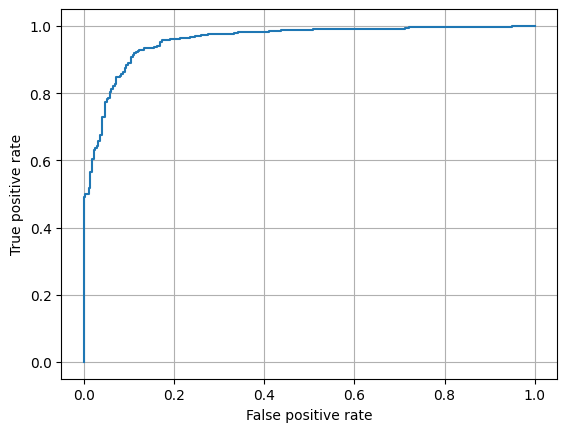

In [34]:
def roc(labels, predictions, ):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid(True)
    
roc(y_true, y_pred[...,0])

<a id='7'></a>
# TESTING

This snippet of code analyses an image and evaluates a binary classification model (previously defined). The image is loaded, preprocessed to match the input size of the model, and then the model is used to make a prediction. It indicates whether the image is classified as "Benign" or "Malignant" based on the prediction result.

In [37]:
image="/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-002.png"

In [38]:
im_array = img_to_array(load_img(image, target_size = (INPUT_DIM, INPUT_DIM)))
if(model.predict(tf.expand_dims(im_array, axis =0))):
    print("It's benign")
else:
    print("Maligant")

1/1 [==============================] - 0s 21ms/step
It's benign


<a id='8'></a>
# CONCLUSION

In this scenario, a TensorFlow-based deep learning model using the RESNET50 architecture is created for the classification of images showing breast cancer histology. The code prepares the data, defines unique performance metrics and loss functions, and trains the model while monitoring crucial metrics. An image test is finally labelled as "Benign" or "Malignant." This thorough workflow shows the procedures needed to set up a binary classification model for medical image analysis, which can be used for actual breast cancer research and diagnosis.
